In [1]:
import sys
import os

# Go up one level to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(project_root)

In [2]:
import torch

from util.config_util import ShapeConfig, dotdict
from data.priors.LaTPFN_dataset import LaTPFNDataset


In [3]:
hyperprior_params= dotdict({
    "a_min": -12.0, "a_max": 12.0,  "a_fixed_variance": 0.15,
    "m_min": -6.0,  "m_max": 6.0,   "m_fixed_variance": 0.15,
    "w_min": -3.0,  "w_max": 3.0,   "w_fixed_variance": 0.15,
    "trend_lin_min": -0.015,  "trend_lin_max": 0.015,   "trend_lin_fixed_variance": 0.005,
    "trend_exp_min": 0.995,   "trend_exp_max": 1.5,   "trend_exp_fixed_variance": 0.001,
    "trend_exp_multiplier": 400,
    "noise_k_min": 0.5,   "noise_k_max": 3.5,
    "resolution_min": 0.1,  "resolution_max": 1.2,  "resolution_multiplier": 50,
    "harmonics_min": 2,   "harmonics_max": 8,
    "discreteness_min": 1,  "discreteness_max": 6,
    "bias_zi_min": 0.8,   "bias_zi_max": 3.0,
    "amplitude_min": 0.5,   "amplitude_max": 4.0,
    "non_negative_prob": 0.2,
    "offset_lin_min": -1.0,   "offset_lin_max": 1.2,
    "offset_exp_min": -1.5,   "offset_exp_max": 2.0,
    "f_zi_min": 0.0,    "f_zi_max": 0.6,  "f_zi_fixed_variance": 0.3,
    #new from joseph
    'p_add': 0.5, #Change this between 0.1, 0.25, and 0.5
    'trend_damp_min': 0.2, 'trend_damp_max':0.3
  })

In [4]:
shape_config = ShapeConfig(
    n_context=2,
    n_sequence=2_000,  # Length of synthetic series
    n_features=1,    # Univariate series
    n_heldout=1,
    n_prompt=1
)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_dataset = LaTPFNDataset(
            shape=shape_config,
            hyperprior_params=hyperprior_params,
            batch_size=1,
            length=shape_config.n_sequence,
            is_train=False,
            device=device,
            return_components=False,
            scale_noise=True,
            separate_noise=False  # Single values only
        )

Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x70e524568e20> {}


In [6]:
t, v, _ = base_dataset.get_a_context()

In [7]:
from data.priors.LaTPFN_prior.sampling import (
    double_sampling,
    triple_sampling,
    noise_scale_sampling,
)
from torch.distributions.uniform import Uniform
from torch.distributions.categorical import Categorical

In [8]:
import random

def sample_from_hyperpriors(shape=shape_config, hpp=hyperprior_params):
    n_context = shape.n_context
    n_sequence = shape.n_sequence

    result = dotdict()

    for param, min_val, max_val, fixed_variance in [
        ("annual_param", hpp.a_min, hpp.a_max, hpp.a_fixed_variance),
        ("monthly_param", hpp.m_min, hpp.m_max, hpp.m_fixed_variance),
        ("weekly_param", hpp.w_min, hpp.w_max, hpp.w_fixed_variance),
        ("frequency_zero_inflation", hpp.f_zi_min, hpp.f_zi_max, hpp.f_zi_fixed_variance),  # noqa
        ("trend_lin", hpp.trend_lin_min, hpp.trend_lin_max, hpp.trend_lin_fixed_variance),  # noqa
    ]:
        result[param] = triple_sampling(
            hyperprior_min=min_val,
            hyperprior_max=max_val,
            fixed_variance=fixed_variance,
            num_samples=n_context,
            device=device,
        )

    # make it equally likely to have a positive or negative exp trend

    mm = hpp.trend_exp_multiplier  
    # f_exp = lambda x: 2 ** ((x - 1) * mm)
    # f_exp_inv = lambda x: (torch.log2(x) / mm) + 1
    
    # shrink effective multiplier as series span grows to keep base^(time) bounded
    # approximate upper span by n_sequence / resolution_min
    span_upper = n_sequence / hpp.resolution_min
    mm_eff = hpp.trend_exp_multiplier / span_upper
    f_exp      = lambda x: 2 ** ((x - 1) * mm_eff)
    f_exp_inv  = lambda x: (torch.log2(x) / mm_eff) + 1


    result.trend_exp = f_exp_inv(
        triple_sampling(
            hyperprior_min=f_exp(torch.scalar_tensor(hpp.trend_exp_min)),
            hyperprior_max=f_exp(torch.scalar_tensor(hpp.trend_exp_max)),
            fixed_variance=hpp.trend_exp_fixed_variance,
            num_samples=n_context,
            device=device,
        )
    )

    # ensure consistent sign for trends

    median_lin_sign = result.trend_lin.median().sign()
    result.trend_lin = result.trend_lin.abs() * median_lin_sign

    assert (result.trend_lin >= 0).all() or (
        result.trend_lin <= 0
    ).all(), f"non-consistent sign {result.trend_lin=} in trend_lin"

    median_exp_sign = (result.trend_exp - 1).median().sign()
    result.trend_exp = (result.trend_exp - 1).abs() * median_exp_sign + 1

    assert (result.trend_exp >= 1).all() or (
        result.trend_exp <= 1
    ).all(), f"non-consistent {result.trend_exp=} in trend_exp"

    # sub-context-specific params

    result.noise_k = double_sampling(
        hyperprior_min=hpp.noise_k_min,
        hyperprior_max=hpp.noise_k_max,
        num_samples=n_context,
        device=device,
    )
    result.noise_scale = noise_scale_sampling(n_context, device=device)

    # domain-specific params

    result.discreteness = (
        Uniform(hpp.discreteness_min, hpp.discreteness_max)
        .sample([n_context])
        .to(device)
    )

    result.bias_zi = (
        Uniform(hpp.bias_zi_min, hpp.bias_zi_max).sample([n_context]).to(device)
    )

    result.amplitude = (
        Uniform(hpp.amplitude_min, hpp.amplitude_max).sample([n_context]).to(device)
    )

    result.non_negative = (
        Categorical(
            torch.tensor([1 - hpp.non_negative_prob, hpp.non_negative_prob])
        )
        .sample()
        .to(device)
        .repeat(n_context)
    )

    result.offset_lin = (
        Uniform(hpp.offset_lin_min, hpp.offset_lin_max)
        .sample([n_context])
        .to(device)
    )

    result.offset_exp = (
        Uniform(hpp.offset_exp_min, hpp.offset_exp_max)
        .sample([n_context])
        .to(device)
    )

    result.harmonics = torch.randint(hpp.harmonics_min, hpp.harmonics_max, (3,)).to(
        device
    )

    # keep the n-days at a set median

    mm = hpp.resolution_multiplier
    f_res = lambda x: torch.log2(x * mm + 1)
    f_res_inv = lambda x: (2**x - 1) / mm

    result.resolution = (
        f_res_inv(
            Uniform(
                f_res(torch.scalar_tensor(hpp.resolution_min)),
                f_res(torch.scalar_tensor(hpp.resolution_max)),
            ).sample()
        )
        .to(device)
        .repeat(n_context)
    )

    result.n_units = torch.ceil(n_sequence / result.resolution)

    #new for joseph
    result.p_add = random.random() < hpp.p_add
    result.trend_damp = Uniform(hpp.trend_damp_min,hpp.trend_damp_max).sample()

    return result

In [9]:
component_params = sample_from_hyperpriors()


In [10]:
from data.priors.LaTPFN_prior.series_components import (
    generate_trend_component,
    generate_seasonal_component,
    generate_noise_component,
)

In [11]:
def make_multiple_series(n_context: int, sequence_length: int, num_features: int,
                         device: str, component_params: dotdict, return_components: bool = False,  # For debugging and visualization purposes
                         scale_noise: bool = True, equal_spacing: bool = True,):
    if not equal_spacing:
        x = (
            (
                torch.rand(n_context, sequence_length, num_features, device=device)
                * component_params.n_units.unsqueeze(-1).unsqueeze(-1)
            )
            .squeeze()
            .to(device)
        )

        x, _ = torch.sort(x, dim=1)
    else:
        x = torch.linspace(0, 1, sequence_length, device=device).unsqueeze(0).repeat(
            n_context, 1
        ).unsqueeze(-1) * component_params.n_units.unsqueeze(-1).unsqueeze(-1)
        x = x.squeeze().to(device)

    trend_comp_total, trend_comp_linear, trend_comp_exponential = (
        generate_trend_component(
            trend_linear_scaler=component_params.trend_lin,
            trend_exp_scaler=component_params.trend_exp,
            offset_linear=component_params.offset_lin,
            offset_exp=component_params.offset_exp,
            x=x,
        )
    )

    seasonal_components = generate_seasonal_component(
        annual_param=component_params.annual_param,
        monthly_param=component_params.monthly_param,
        weekly_param=component_params.weekly_param,
        x=x,
        n_units=component_params.n_units,
        n_harmonics=component_params.harmonics,
        device=device,
    )

    total_seasonality, annual_seasonality, monthly_seasonality, weekly_seasonality = (
        seasonal_components[:, :, 0],
        seasonal_components[:, :, 1],
        seasonal_components[:, :, 2],
        seasonal_components[:, :, 3],
    )
    # total_seasonality = total_seasonality.clamp(0.1, 10.0)

    # noisless_values = trend_comp_total * total_seasonality
    if component_params.p_add:
        #print('were adding')
        noisless_values= component_params.amplitude[:, None] * (component_params.trend_damp*trend_comp_total + total_seasonality)
    else:
        noisless_values= component_params.amplitude[:, None] * (trend_comp_total * total_seasonality)

    noise_mean = torch.ones_like(component_params.noise_k)

    weibull_noise_term = generate_noise_component(
        k=component_params.noise_k,
        noise_mean=noise_mean,
        shape=(x.shape[0], x.shape[1]),
        device=device,
    )

    noise = 1 + component_params.noise_scale.unsqueeze(-1) * (
        weibull_noise_term - noise_mean.unsqueeze(-1)
    )

    if scale_noise:
        noise = noise * trend_comp_total
        # lvl = (trend_comp_total / trend_comp_total.mean(dim=1, keepdim=True)).sqrt()
        # noise = 1 + (lvl - 1) * component_params.noise_scale.unsqueeze(-1) * (
        #     weibull_noise_term - noise_mean.unsqueeze(-1)
        # )

    return x, noisless_values, noise, trend_comp_total, total_seasonality

torch.Size([2000])


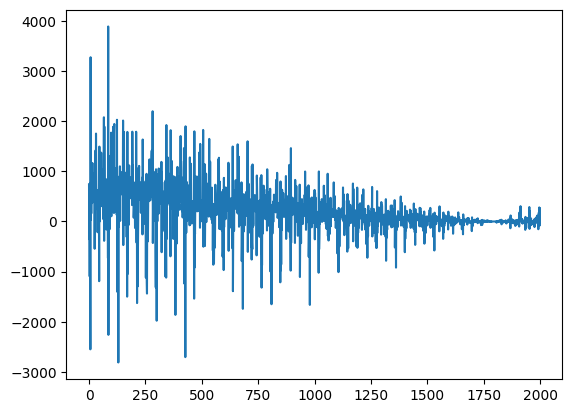

In [12]:
import matplotlib.pyplot as plt


component_params = sample_from_hyperpriors()

t, v, noise, trend, season = make_multiple_series(shape_config.n_context, shape_config.n_sequence, num_features=1, device=device, component_params=component_params, return_components=False, scale_noise=True)
s = v[0,:] * noise[0,:]
print(s.shape)
plt.plot(s.cpu())

In [13]:
component_params

{'annual_param': tensor([-9.7388, -9.6529], device='cuda:0'),
 'monthly_param': tensor([4.9953, 5.3441], device='cuda:0'),
 'weekly_param': tensor([1.1589, 1.2754], device='cuda:0'),
 'frequency_zero_inflation': tensor([0.5952, 0.2301], device='cuda:0'),
 'trend_lin': tensor([0.0028, 0.0044], device='cuda:0'),
 'trend_exp': tensor([1.1079, 1.1344], device='cuda:0'),
 'noise_k': tensor([1.6579, 2.3462], device='cuda:0'),
 'noise_scale': tensor([0.1899, 0.0713], device='cuda:0'),
 'discreteness': tensor([3.2491, 5.9311], device='cuda:0'),
 'bias_zi': tensor([0.9715, 1.0341], device='cuda:0'),
 'amplitude': tensor([1.7739, 2.7373], device='cuda:0'),
 'non_negative': tensor([0, 0], device='cuda:0'),
 'offset_lin': tensor([0.9162, 0.7754], device='cuda:0'),
 'offset_exp': tensor([ 0.9400, -1.3596], device='cuda:0'),
 'harmonics': tensor([4, 2, 7], device='cuda:0'),
 'resolution': tensor([0.1164, 0.1164], device='cuda:0'),
 'n_units': tensor([17187., 17187.], device='cuda:0'),
 'p_add': True

In [14]:
v = (v * noise).unsqueeze(-1)
v.shape

torch.Size([2, 2000, 1])

In [15]:
y_series = v[0, :, 0]
y_series.shape

torch.Size([2000])

In [16]:
y_series

tensor([ 738.5126, -352.7525,  170.6955,  ...,   37.4035,  269.5388,
         -72.2746], device='cuda:0', dtype=torch.float64)

In [17]:
hyperprior_params= dotdict({
    "a_min": -12.0, "a_max": 12.0,  "a_fixed_variance": 0.15,
    "m_min": -6.0,  "m_max": 6.0,   "m_fixed_variance": 0.15,
    "w_min": -3.0,  "w_max": 3.0,   "w_fixed_variance": 0.15,
    "trend_lin_min": -0.015,  "trend_lin_max": 0.015,   "trend_lin_fixed_variance": 0.005,
    "trend_exp_min": 0.995,   "trend_exp_max": 1.5,   "trend_exp_fixed_variance": 0.001,
    "trend_exp_multiplier": 400,
    "noise_k_min": 0.5,   "noise_k_max": 3.5,
    "resolution_min": 0.1,  "resolution_max": 1.2,  "resolution_multiplier": 50,
    "harmonics_min": 2,   "harmonics_max": 8,
    "discreteness_min": 1,  "discreteness_max": 6,
    "bias_zi_min": 0.8,   "bias_zi_max": 3.0,
    "amplitude_min": 0.5,   "amplitude_max": 4.0,
    "non_negative_prob": 0.2,
    "offset_lin_min": -1.0,   "offset_lin_max": 1.2,
    "offset_exp_min": -1.5,   "offset_exp_max": 2.0,
    "f_zi_min": 0.0,    "f_zi_max": 0.6,  "f_zi_fixed_variance": 0.3,
    #new from joseph
    'p_add': 0.5, #Change this between 0.02, 0.1, 0.25, and 0.5
    'trend_damp_min': 0.2, 'trend_damp_max':0.3
  })


In [18]:
import json, glob
import numpy as np
from pathlib import Path
import math
from tqdm import tqdm

n_sequence = 2_000
n_series  = 100_000
print(n_sequence)
shape_config = ShapeConfig(
    n_context=2,
    n_sequence=n_sequence,  # Length of synthetic series
    n_features=1,    # Univariate series
    n_heldout=1,
    n_prompt=1
)

shard_sz  = 2_000
dtype     = np.float32
seed      = 42
device    = "cpu"

for v in [0.02, 0.1, 0.25, 0.5]:
    out_dir   = f"../series_bank/v{v}"
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    torch.manual_seed(seed); np.random.seed(seed)
    hyperprior_params.p_add = v
    # snapshot meta for reproducibility
    meta = {
        "n_series": n_series,
        "shard_size": shard_sz,
        "dtype": "float32",
        "seed": seed,
        "n_sequence": n_sequence,
        "hyperprior_params": dict(hyperprior_params),
    }
    Path(out_dir, "meta.json").write_text(json.dumps(meta, indent=2))


    num_shards = math.ceil(n_series / shard_sz)
    idx = 0

    for s in tqdm(range(num_shards), desc='num_shards'):
        k = min(shard_sz, n_series - idx)
        buf = np.empty((k, n_sequence), dtype=dtype)

        for i in tqdm(range(k), desc='k', leave=False):
            # synth
            component_params = sample_from_hyperpriors(shape_config, hyperprior_params)
            t, v, noise, trend, season = make_multiple_series(shape_config.n_context, shape_config.n_sequence, num_features=1, device=device, component_params=component_params, return_components=False, scale_noise=True)
            y = v[0,:] * noise[0,:]
            y = y.contiguous().float()
            
            buf[i] = y.cpu().numpy().astype(dtype)

        np.save(Path(out_dir, f"series_shard_{s:04d}.npy"), buf)
        idx += k


2000


num_shards:   0%|          | 0/50 [00:00<?, ?it/s]